In [6]:
import tensorflow as tf
import tensorflow.keras.layers as tfkl
import numpy as np
import utils.read_data as read_data
import importlib

In [7]:
data = read_data.LidarData(category='data_neon')

In [9]:
# number of points in each sample
n_points = 1024
# number of categories
n_features = 128
# epoch number
n_epochs = 50
# define optimizer
optimizer = tf.optimizers.Adam(learning_rate=0.001, decay=0.7)

In [10]:
def matmul(A, B):
    return tf.matmul(A, B)

def tile(feature, n_points):
    return tf.tile(feature, [1, num_points, 1])

In [11]:
def input_transform_net(point_cloud):
    x = tfkl.Convolution1D(64, 1, activation='relu', 
                                    input_shape=(n_points, 3))(point_cloud)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Convolution1D(128, 1, activation='relu')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Convolution1D(1024, 1, activation='relu')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.MaxPool1D(pool_size=n_points)(x)
    x = tfkl.Dense(512, activation='relu')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dense(256, activation='relu')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dense(9, weights=[np.zeros((256, 9)), 
                        np.eye(3).flatten().astype(np.float32)])(x)
    return tfkl.Reshape((3, 3))(x)

def feature_transform_net(inputs):
    x = tfkl.Convolution1D(64, 1, activation='relu')(inputs)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Convolution1D(128, 1, activation='relu')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Convolution1D(1024, 1, activation='relu')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.MaxPool1D(pool_size=n_points)(x)
    x = tfkl.Dense(512, activation='relu')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dense(256, activation='relu')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dense(64 * 64, weights = [np.zeros((256, 64 * 64)), 
                                     np.eye(64).flatten().astype(np.float32)])(x)
    return tfkl.Reshape((64, 64))(x)

def compute_cosine_distances(a, b):
    # x shape is n_a * dim
    # y shape is n_b * dim
    # results shape is n_a * n_b

    normalize_a = tf.nn.l2_normalize(a,1)        
    normalize_b = tf.nn.l2_normalize(b,1)
    distance = 1 - tf.matmul(normalize_a, normalize_b, transpose_b=True)
    return distance

In [12]:
def l2_loss(y_true, y_pred):
    loss = tf.norm(y_true - y_pred, axis=(1, 2))
    return tf.reduce_mean(loss, axis=-1)

In [13]:
def PointNet(cosine=False):
    point_cloud = tfkl.Input(shape=(n_points, 3))

    input_t = input_transform_net(point_cloud)
    # x = tfkl.Lambda(matmul, arguments={'B': input_t})(point_cloud)
    x = tf.matmul(point_cloud, input_t)

    x = tfkl.Convolution1D(64, 1, activation='relu')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Convolution1D(64, 1, activation='relu')(x)
    x = tfkl.BatchNormalization()(x)

    feature_t = feature_transform_net(x)
    # x = tfkl.Lambda(matmul, arguments={'B': feature_t})(x)
    x = tf.matmul(x, feature_t)
    seg = x

    x = tfkl.Convolution1D(64, 1, activation='relu')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Convolution1D(128, 1, activation='relu')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Convolution1D(1024, 1, activation='relu')(x)
    x = tfkl.BatchNormalization()(x)

    feature = tfkl.MaxPool1D(pool_size=n_points)(x)
    # feature = tfkl.Lambda(tf.tile, arguments={'n_points': n_points})(feature)
    feature = tf.tile(feature, [1, n_points, 1])

    combined = tfkl.concatenate([seg, feature])
    combined = tfkl.Convolution1D(512, 1, activation='relu')(combined)
    combined = tfkl.BatchNormalization()(combined)
    combined = tfkl.Convolution1D(256, 1, activation='relu')(combined)
    combined = tfkl.BatchNormalization()(combined)
    combined = tfkl.Convolution1D(128, 1, activation='relu')(combined)
    combined = tfkl.BatchNormalization()(combined)
    combined = tfkl.Convolution1D(128, 1, activation='relu')(combined)
    combined = tfkl.BatchNormalization()(combined)

    features = tfkl.Convolution1D(n_features, 1, activation='relu')(combined)
    if cosine:
        similarities = compute_cosine_distances(features, features)
    else:
        r = tf.reduce_sum(features * features, 2)
        r = tf.reshape(r, [-1, n_points, 1])
        similarities = tf.clip_by_value(r - 2 * tf.matmul(features, tf.transpose(features, perm=[0, 2, 1])) + tf.transpose(r, perm=[0, 2, 1]),0,1)
    return tf.keras.Model(inputs=point_cloud, outputs=similarities)

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(data.x, data.y, test_size=0.2)

pointnet = PointNet(cosine=False)
pointnet.compile(optimizer=optimizer, loss=l2_loss)

In [16]:
history = pointnet.fit(x_train, y_train, epochs=5, batch_size=8, validation_data=(x_val, y_val))

Epoch 1/5
37/37 [==============================] - 37s 1s/step - loss: 833.7945 - val_loss: 872.0436
Epoch 2/5
37/37 [==============================] - 37s 1s/step - loss: 833.4816 - val_loss: 870.2245
Epoch 3/5
37/37 [==============================] - 38s 1s/step - loss: 833.6317 - val_loss: 868.0428
Epoch 4/5
37/37 [==============================] - 37s 1s/step - loss: 833.6589 - val_loss: 867.4113
Epoch 5/5
37/37 [==============================] - 38s 1s/step - loss: 834.5607 - val_loss: 866.4135


dict_keys(['loss', 'val_loss'])


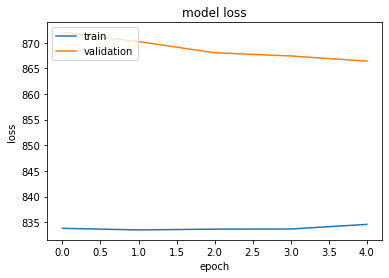

In [17]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()